In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import sys
thismodule = sys.modules[__name__]
import torch
import numpy as np
import cv2
import json
import model
from data.ar0820_raw2rgb import load_ar0820_image
from utils.data_utils import gram_schmidt
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from scipy.spatial.transform import Rotation
import imageio

In [3]:
def crop_img(img:np.ndarray, crop_height:int, crop_width:int)->np.ndarray:
    """create central crop for the image

    Args:
        img (np.ndarray): input image
        crop_height (np.ndarray): _description_
        crop_width (np.ndarray): _description_

    Returns:
        np.ndarray: central cropped image
    """
    height,width = img.shape[:2]
    top = (height - crop_height)//2
    left = (width - crop_width)//2
    bottom = (height + crop_height)//2
    right = (width + crop_width)//2

    return img[top:bottom,left:right,...]

In [4]:
root = '/nas/EOS/dataset/torc/wk2/fixed_structure/CAPT-199'
seq = 'afternoon_CAPT-199_20211117172655'
cam_type = 'ar0820'
rgb_dir = os.path.join(root,seq,cam_type)
calib_dir = os.path.join(root,'calibration_matrix')

In [5]:
weights_path = '/nas/EOS/users/aman/logs/stereo_pose_estimation/exp-2_siamese_6D/models/weights_19/pose.pth'
weights_path = '/nas/EOS/users/aman/logs/stereo_pose_estimation/exp-6_siamese_6D_carla_lr_0.0002_2/models/weights_76/pose.pth'

In [6]:
rot_model = model.RotationNet(n_out=6)
pretrained_dict = torch.load(weights_path)

model_dict = rot_model.state_dict()
model_dict.update(pretrained_dict)
rot_model.load_state_dict(model_dict,strict=False)
rot_model.cuda()
_ = rot_model.eval()

In [7]:
to_tensor = transforms.ToTensor()

In [8]:
# Load RGB data
raw_paths = []
rgb_imgs = []
for i in range(4):
    raw_paths.append(os.path.join(rgb_dir,f'image{i}',f'frame_image{i}_00010000.raw'))
    rgb_imgs.append(load_ar0820_image(raw_paths[-1]))


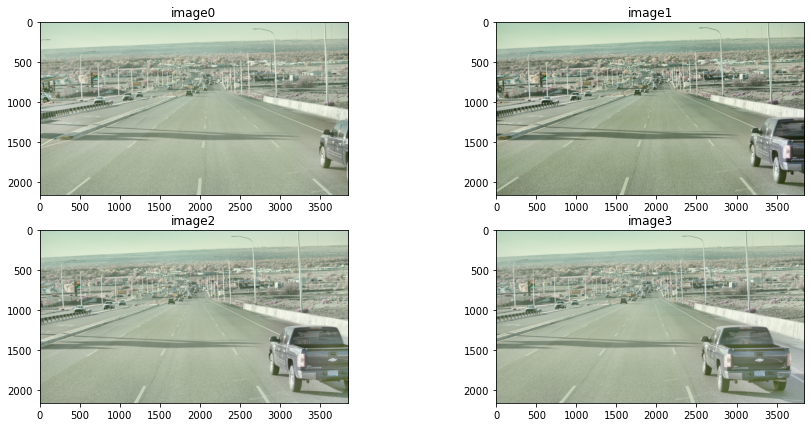

In [9]:
fig,axes = plt.subplots(2,2,figsize=(15,7))
axes[0,0].imshow(rgb_imgs[0][...,::-1])
axes[0,0].set_title('image0')
axes[0,1].imshow(rgb_imgs[1][...,::-1])
axes[0,1].set_title('image1')
axes[1,0].imshow(rgb_imgs[2][...,::-1])
axes[1,0].set_title('image2')
axes[1,1].imshow(rgb_imgs[3][...,::-1])
axes[1,1].set_title('image3')
fig.show()

In [10]:
# Load calibration data
with open(os.path.join(calib_dir,'camera_intrinsic.json')) as fh:
    intrinsics = json.load(fh)
with open(os.path.join(calib_dir,'camera_extrinsic.json')) as fh:
    extrinsics = json.load(fh)

In [11]:
undist_rgb_imgs = []
# undistort RGB images to pass to the network
for i in range(4):
    undist_rgb_imgs.append(cv2.undistort(rgb_imgs[i],
                                         np.array(intrinsics[f'{cam_type}_{i}']['cam_mat']).reshape(3,3),
                                         np.array(intrinsics[f'{cam_type}_{i}']['dist']).reshape(-1))
                            )

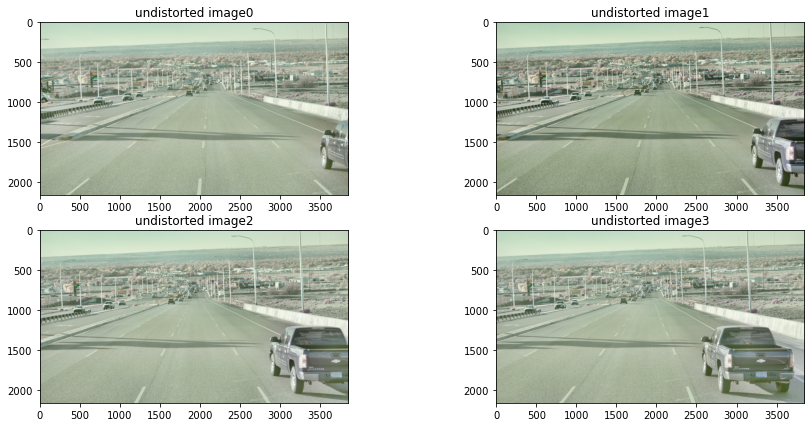

In [12]:
fig,axes = plt.subplots(2,2,figsize=(15,7))
axes[0,0].imshow(undist_rgb_imgs[0][...,::-1])
axes[0,0].set_title('undistorted image0')
axes[0,1].imshow(undist_rgb_imgs[1][...,::-1])
axes[0,1].set_title('undistorted image1')
axes[1,0].imshow(undist_rgb_imgs[2][...,::-1])
axes[1,0].set_title('undistorted image2')
axes[1,1].imshow(undist_rgb_imgs[3][...,::-1])
axes[1,1].set_title('undistorted image3')
fig.show()

In [13]:
target_id, ref_id = 0, 1
target = Image.fromarray(crop_img(cv2.cvtColor(undist_rgb_imgs[target_id],
                                               cv2.COLOR_BGR2RGB),
                                  256,
                                  512))
ref = Image.fromarray(crop_img(cv2.cvtColor(undist_rgb_imgs[ref_id],
                                            cv2.COLOR_BGR2RGB),
                                256,
                                512))

In [14]:
ref = to_tensor(ref).unsqueeze(0).cuda()
target = to_tensor(target).unsqueeze(0).cuda()

In [15]:
with torch.no_grad():
    pred_rotation = rot_model(target, ref)
pred_rotation = pred_rotation.cpu()
pred_rotation = pred_rotation.reshape(-1, 6)
pred_rmat = gram_schmidt(pred_rotation[:, :3], pred_rotation[:, 3:]).numpy()[0]
pred_axisangles = Rotation.from_matrix(gram_schmidt(
    pred_rotation[:, :3], pred_rotation[:, 3:]).numpy()).as_rotvec(degrees=True).astype(np.float32)

In [16]:
gt_rmat = np.array(extrinsics[f'{cam_type}_{target_id}_{cam_type}_{ref_id}']['rvec']).reshape(3,3)
gt_axisangles = Rotation.from_matrix(np.array(extrinsics[f'{cam_type}_{target_id}_{cam_type}_{ref_id}']['rvec']).reshape(
    3, 3)).as_rotvec(degrees=True).astype(np.float32)

In [17]:
gt_axisangles

array([ 0.3054789,  1.8431848, -0.4975992], dtype=float32)

In [18]:
pred_axisangles

array([[ 0.0601832,  0.6013048, -1.0688585]], dtype=float32)

### Calibrating the images

In [19]:
def calibrate_stereo_pair(img_left, img_right, K_left, K_right, dist_left, dist_right, R, t, height, width):
    # Getting left and right rectify maps
    R1,R2,P1,P2,Q,roi_left, roi_right = cv2.stereoRectify(K_left,dist_left,K_right,dist_right,
                                                          (width,height),R,t,flags=cv2.CALIB_ZERO_DISPARITY)

    maplx,maply = cv2.initUndistortRectifyMap(K_left,dist_left,R1,P1,(width,height),cv2.CV_32FC1)
    maprx,mapry = cv2.initUndistortRectifyMap(K_right,dist_right,R2,P2,(width,height),cv2.CV_32FC1)

    img_left_rect = cv2.remap(img_left, maplx, maply, cv2.INTER_LINEAR)
    img_right_rect = cv2.remap(img_right, maprx, mapry, cv2.INTER_LINEAR)

    return img_left_rect, img_right_rect

In [20]:
def draw_epipolar_lines(image1,image2, num_lines = 100,line_color=(0,255,0), line_thickness=2):
    assert image1.shape == image2.shape, "two image dimensions are of different dimensions"
    h,w,_ = image1.shape
    comb = np.concatenate((image1,image2),axis=1) # concatenating along width dimesnion
    delta = h//num_lines
    left_indxs = np.arange(0, h, delta)
    for indx in left_indxs:
        cv2.line(comb, (0,indx),(2*w,indx),line_color,line_thickness)
        
    return comb

In [21]:
def gen_epipolar_gif(image1,image2, savepath, num_lines = 100,line_color=(0,255,0), line_thickness=2):
    left = image1.copy()
    right = image2.copy()
    assert image1.shape == image2.shape, "two image dimensions are of different dimensions"
    h,w,_ = image1.shape
    delta = h//num_lines
    left_indxs = np.arange(0, h, delta)
    for img in [left,right]:
        for indx in left_indxs:
            cv2.line(img, (0,indx),(2*w,indx),line_color,line_thickness)
    images = []
    for image in [left,right]:
        images.append(image)
    imageio.mimsave(savepath, images, format='GIF', duration=0.5)


In [22]:
gt_rectf_left, gt_rectf_right = calibrate_stereo_pair(rgb_imgs[target_id],rgb_imgs[ref_id],
                                                np.array(intrinsics[f'{cam_type}_{target_id}']['cam_mat']).reshape(3,3),
                                                np.array(intrinsics[f'{cam_type}_{ref_id}']['cam_mat']).reshape(3,3),
                                                np.array(intrinsics[f'{cam_type}_{target_id}']['dist']).reshape(-1),
                                                np.array(intrinsics[f'{cam_type}_{ref_id}']['dist']).reshape(-1),
                                                gt_rmat,
                                                np.array(extrinsics[f'{cam_type}_{target_id}_{cam_type}_{ref_id}']['tvec']).reshape(3),
                                                2160,3848)

In [23]:
pred_rectf_left, pred_rectf_right = calibrate_stereo_pair(rgb_imgs[target_id],rgb_imgs[ref_id],
                                                np.array(intrinsics[f'{cam_type}_{target_id}']['cam_mat']).reshape(3,3),
                                                np.array(intrinsics[f'{cam_type}_{ref_id}']['cam_mat']).reshape(3,3),
                                                np.array(intrinsics[f'{cam_type}_{target_id}']['dist']).reshape(-1),
                                                np.array(intrinsics[f'{cam_type}_{ref_id}']['dist']).reshape(-1),
                                                pred_rmat.astype(gt_rmat.dtype),
                                                np.array(extrinsics[f'{cam_type}_{target_id}_{cam_type}_{ref_id}']['tvec']).reshape(3),
                                                2160,3848)

In [24]:
gt_ep_pair = draw_epipolar_lines(gt_rectf_left,gt_rectf_right,30,(255,0,0))
pred_ep_pair = draw_epipolar_lines(pred_rectf_left,pred_rectf_right,30,(255,0,0))

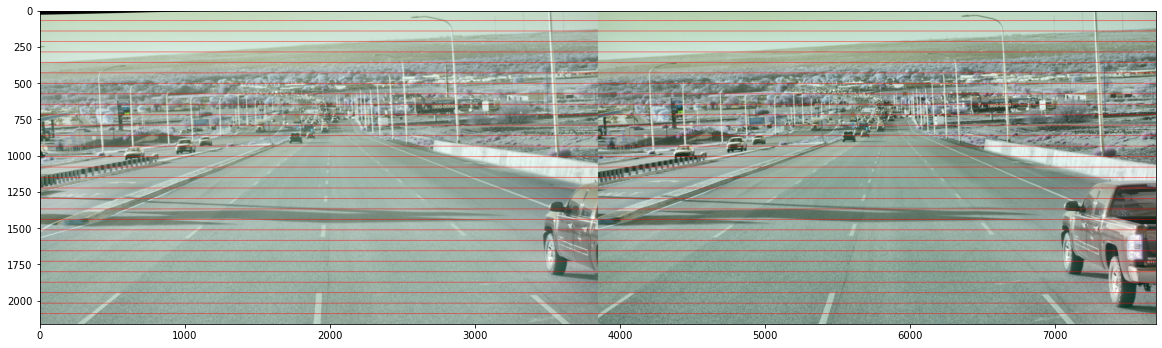

In [25]:
figure,axes = plt.subplots(1,1,figsize=(20,10))
axes.imshow(gt_ep_pair)
figure.show()

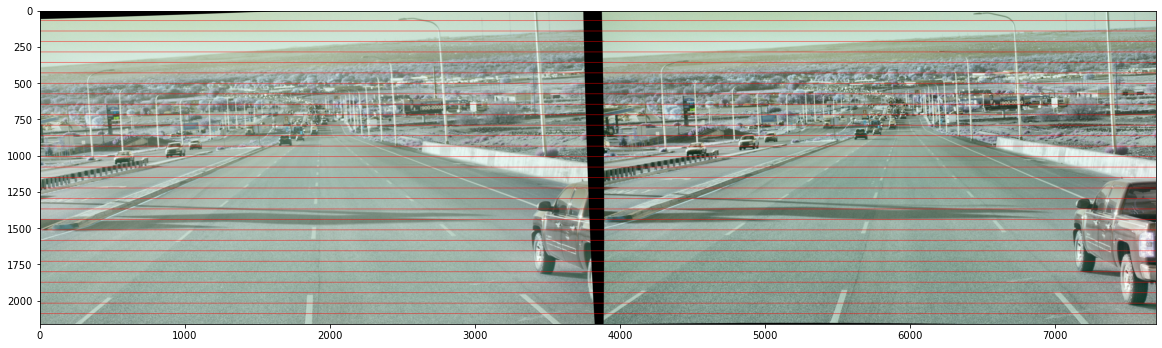

In [26]:
figure,axes = plt.subplots(1,1,figsize=(20,10))
axes.imshow(pred_ep_pair)
figure.show()

In [85]:
savepath = os.path.join('/home/amanpreet.walia/workspace/repos/eos_depth/RelativePoseEstimation/assets','gt.gif')
gen_epipolar_gif(gt_rectf_left,gt_rectf_right,savepath,num_lines=50)

In [86]:
savepath = os.path.join('/home/amanpreet.walia/workspace/repos/eos_depth/RelativePoseEstimation/assets','pred.gif')
gen_epipolar_gif(pred_rectf_left,pred_rectf_right,savepath,num_lines=50)

In [27]:
np.array(intrinsics[f'{cam_type}_{ref_id}']['dist']).reshape(-1).shape

(8,)